In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Data Preparation

### Demand scalling

The demand data has been scalled based on annual electricity consumption available at [AGEB](https://ag-energiebilanzen.de/7-0-Bilanzen-1990-2016.html) for the year 2009 to 2016. 

For 2017, since the data is not updated at AGEB, it has been scalled based on ENTSO-E [factsheet](https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet).

In [4]:
dem_unscalled = pd.read_csv(os.path.abspath('Load/demand_unscalled.csv')).rename(columns={'Unnamed: 0': 'h'}).set_index('h').dropna()

In [8]:
demTotENTSOE_powerStat = (dem_unscalled.sum(axis=0)/1000000).values
demTotENTSOE_factsheet = [495.2, 527.4, 521.2, 523.3, 523.2, 512.8, 514.7, 517.6, 538.7]
demScalled = dem_unscalled*(demTotENTSOE_factsheet/demTotENTSOE_powerStat)

In [14]:
demScalled.to_csv('demand_scalled.csv')

# Reading data

### Demand

In [6]:
demandAll = pd.read_csv('Load/demand_scalled.csv').rename(columns={'Unnamed: 0':'h'}).set_index('h')

### Capacity Factors

In [7]:
pvCF = pd.read_csv(os.path.abspath('Res_CF/pvCF_EMIHRES.csv'))
wonCF = pd.read_csv(os.path.abspath('Res_CF/wonCF_EMIHRES.csv'))
woffCF = pd.read_csv(os.path.abspath('Res_CF/woffCF_EMIHRES.csv'))

pvCFMeera = pd.read_csv(os.path.abspath('Res_CF/pvCF_NinjaMeera.csv'))
wonCFNinja = pd.read_csv(os.path.abspath('Res_CF/wonCF_Ninja.csv'))
woffCFNinja = pd.read_csv(os.path.abspath('Res_CF/woffCF_Ninja.csv'))

# Scenarios

## Renewables

In [8]:
# Best Case
pvCap_b   = 50334 
wonCap_b  = 64691 
woffCap_b =  9446

# Worst Case
pvCap_w   = 50334 
wonCap_w  = 54691 
woffCap_w =  7127

## Reliable Capacity

In [17]:
# including PSP (only local)
reliableCap_pumpLocalOnly = 75547

# including PSP (local + cross border capacity connnected to Germany)
reliableCap_pump = 78547

# exluding PSP
reliableCap_noPump = 68621

In [18]:
# colors for scenarios
c_noPump = '#C0392B'
c_pump = '#16A085'

# Analysis


In [11]:
outLoc ='/Users/samarth/Desktop/Work/24_coalPhaseOut/draft/'

In [12]:
def getResLoad(pvCap, wonCap, woffCap):
    resLoad = pd.DataFrame()
    for demYear in demandAll:
        for wYear in range(1986,2016,1):
            insRESLoad = pd.DataFrame(demandAll[str(demYear)] - 
                                      pvCF[str(wYear)]*pvCap-
                                      wonCF[str(wYear)]*wonCap-
                                      woffCF[str(wYear)]*woffCap, 
                                      columns=[str(demYear)+'_'+str(wYear)])
            resLoad = resLoad.join(insRESLoad, how='outer')
    
    for demYear in demandAll:
        for wYear in range(1986,2016,1):
            insRESLoad = pd.DataFrame(demandAll[str(demYear)] - 
                                      pvCFMeera[str(wYear)]*pvCap-
                                      wonCFNinja[str(wYear)]*wonCap-
                                      woffCFNinja[str(wYear)]*woffCap, 
                                      columns=[str(demYear)+'_'+str(wYear)+'_ninja'])
            resLoad = resLoad.join(insRESLoad, how='outer')
    return resLoad

In [13]:
resLoad_b  = getResLoad(pvCap_b,wonCap_b,woffCap_b)
resLoad_w  = getResLoad(pvCap_w,wonCap_w,woffCap_w)

In [23]:
def plotResLoad(resLoad, reliableCap):
    resLoadSort = resLoad.values
    resLoadSort.sort(axis=0)
    plt.plot(resLoadSort, color='b',alpha=0.01);
    plt.hlines(reliableCap, xmin=0, xmax=8760)
    plt.xlim([])
    plt.show()

In [58]:
def getMaxResLoads(resLoad):
    maxLoads = []
    for col in resLoad.columns:
        maxLoads.append(resLoad[col].max())
        
    return maxLoads

### Distribution of peak residual load

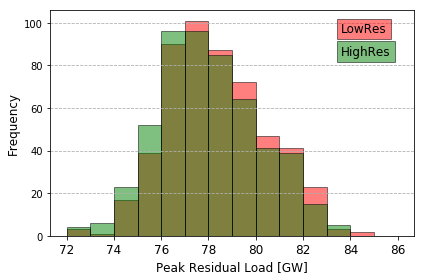

In [72]:
fig, ax = plt.subplots()
maxValues_w = getMaxResLoads(resLoad_w)
(pd.DataFrame(maxValues_w)/1000).plot(kind='hist', bins=14, range=(72,86), 
                                      ax=ax,
                                     # label='highRes', 
                                    legend=False,
                                      align ='mid',
                                     edgecolor='k', color='red', alpha=0.5)

maxValues_b = getMaxResLoads(resLoad_b)
(pd.DataFrame(maxValues_b)/1000).plot(kind='hist', bins=14, range=(72,86), 
                                      ax=ax,
                                      #label='lowRes',
                                      legend=False,
                                      edgecolor='k', color='green', alpha=0.5)
plt.ylabel('Frequency', size=12)
plt.xlabel('Peak Residual Load [GW]', size=12)
plt.xticks(size=12)
plt.grid( axis='y', linestyle = '--')
plt.tight_layout()
#plt.savefig(outLoc+'/PeakLoadDiss.pdf')

t = plt.text(0.8, 0.90, 'LowRes', transform=ax.transAxes, fontsize=12)
t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='black'))

t = plt.text(0.8, 0.80, 'HighRes', transform=ax.transAxes, fontsize=12)
t.set_bbox(dict(facecolor='green', alpha=0.5, edgecolor='black'))

plt.savefig(outLoc+'/PeakResLoadDiss_2.pdf')
plt.show()


## Calculation for EAR

EAR (Energy at Risk): Energy at risk is calculated as the sum of the LAR over the stress duration combined with the same calculation for the previous stress instances if the previous instance happened within the last 12h. The reason for combining the EAR is to take into account the incapability of the pump storage to charge itself in case of stress situations occurring close to each other. Since the energy/power for the PSP in Germany is around 6, it would take 6 hours to charge to if charging at full power. However, for charging at full capacity the power should be available in the market and the price incentive should be there for charging, hence 12h approximation was taken to combine the stress instances.  

In [14]:
def getContStressStat(resLoad, reliableCap):
    resLoadStress = resLoad.copy()
    resLoadStress[resLoad < reliableCap] = 0
    
    conStat = []
   
    # calculating the hours of stress and the hours since last stress
    for col in resLoadStress.columns:
        resLoadIns = resLoadStress[col].values
        counter_noStress = 0
        for i in range(0,len(resLoadIns),1):

            if resLoadIns[i]==0:
                counter_stress = 0
                excessEnergy = 0
                counter_noStress = counter_noStress + 1 
                
            else:
                counter_stress = counter_stress + 1
                excessEnergy = excessEnergy + resLoadIns[i] - reliableCap
                conStat.append([counter_stress, excessEnergy,resLoadIns[i] - reliableCap, i, counter_noStress+1])
                counter_noStress=0
                
    conStressHoursStat = pd.DataFrame(conStat, 
                                      columns=['conNumHours','excessLoad', 
                                               'excessCap','hour',
                                               'hoursSinceLastStress'])
    instanceCount = 0
    instanceList = []

    # adding the stress counter to be able to 
    # combine different stress hours into stress instances
    
    for row in conStressHoursStat.iterrows():
        if row[1][0]==1:
            instanceCount=instanceCount+1
        instanceList.append(instanceCount)
        
    conStressHoursStat['instanceCount'] = instanceList
    
    maxInfoStressInstance = []
    for instance in range(1,conStressHoursStat['instanceCount'].max(), 1):
        instanceInfo = conStressHoursStat.loc[conStressHoursStat['instanceCount']==instance]
        maxInfoStressInstance.append([instanceInfo['conNumHours'].max(), 
                                      instanceInfo['excessLoad'].max()/1000, 
                                      instanceInfo['hoursSinceLastStress'].max()])

    stressHMaxChar = pd.DataFrame(maxInfoStressInstance, columns=['hours','TotEnergy','hoursSinceLast'])
    
    # adding LAR_max and LAR_mean
    stressHMaxChar['LAR_max [GW]'] = conStressHoursStat[['instanceCount','excessCap']].groupby('instanceCount').max()['excessCap']/1000
    stressHMaxChar['LAR_mean [GW]'] = conStressHoursStat[['instanceCount','excessCap']].groupby('instanceCount').mean()['excessCap']/1000
    
    # combining different stress instances to calculate EAR (12h definition)
    totEnergy2 =[]
    hours2 = []
    for index, row in stressHMaxChar.iterrows():
        if row[2]<=12:
            totEnergy2.append(row[1]+stressHMaxChar.xs(index-1)[1])
            hours2.append(row[0]+stressHMaxChar.xs(index-1)[0])
        else:
            totEnergy2.append(row[1])
            hours2.append(row[0])

    stressHMaxChar['TotEnergy_2'] = totEnergy2
    stressHMaxChar['hours_2'] = hours2
    
    return conStressHoursStat, stressHMaxChar

In [19]:
stressHourChar_pump, stressHourMaxChar_pump = getContStressStat(resLoad=resLoad_b.dropna(axis=1), 
                                                          reliableCap=reliableCap_pump)

In [44]:
stressHourChar_noPump, stressHourMaxChar_noPump = getContStressStat(resLoad=resLoad_b.dropna(axis=1), 
                                                          reliableCap=reliableCap_noPump)

In [15]:
def pltStrHours_hoursSinceLast(stressHMaxChar):
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    stressHMaxChar.plot(kind='scatter', x='hours', 
                          y='hoursSinceLast',
                        ax=ax1,
                        color='k')
    
    meanHoursLast = stressHMaxChar[['hours', 'hoursSinceLast']].groupby('hours').mean()
    
    stressHMaxChar[['hours', 
                    'hoursSinceLast']].groupby('hours').mean().reset_index().plot(kind='scatter', 
                                                                                  x='hours',y='hoursSinceLast', 
                                                                                  ax=ax2)

    ax1.set_ylim([0,5000
                 ])
    ax1.set_xlim([0,19])
    ax2.set_ylim([0,250])
    plt.xticks(np.arange(0,21,1));

# Plotting

In [43]:
def pltHourScatter(stressHMaxChar):
    
    fig, ax1 = plt.subplots(sharex=True)

#    ax2 = ax1.twinx()
#    stressHMaxChar.groupby('hours').count().rename(columns={'hoursSinceLast':'count'}).plot(kind='bar', y='count',
#                                                                                           ax=ax1
#                                                                                           )
#    ax1.set_xlim([0,19])
    # for plotting days since last in color map
    
    days = (stressHMaxChar.hoursSinceLast/24).astype(int)
    days[days>7]=7
    
    
    stressHMaxChar.plot.scatter(x='hours_2', y='TotEnergy_2', colormap='Reds',
                        c='LAR_max [GW]', ax=ax1, 
                        alpha=0.5)
    
    #ax1.set_ylim([0,200000])
    ax1.axhline(y=58, xmin=0, xmax=19,
               linewidth=2, color='k')
    #ax1.set_xlim([0,19])
    plt.ylabel('Energy At Risk (EAR) [GWh]')
    plt.xlabel('Consecutive Load At Risk (LAR) Hours')
    #plt.xticks(np.arange(0,20,1));
    plt.tight_layout()
    #plt.savefig(outLoc+'/energyHours_dis.pdf')

In [56]:
(stressHourMaxChar_noPump.loc[stressHourMaxChar_noPump['TotEnergy_2']>58])['LAR_max [GW]'].max()

14.898406211213922

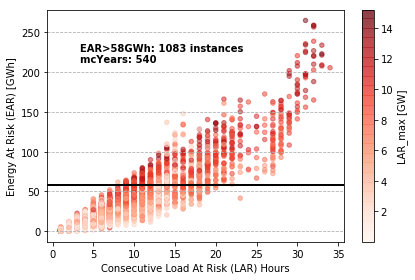

In [46]:
pltHourScatter( stressHourMaxChar_noPump)

plt.text(0.1* stressHourMaxChar_noPump['hours_2'].max(), 
         0.8* stressHourMaxChar_noPump['TotEnergy_2'].max(),
         s='EAR>58GWh: 1083 instances\nmcYears: 540',
         fontweight='bold'
        )

plt.grid(axis='y',linestyle='--')
#plt.savefig(outLoc+'/hours_energyAtRisk_noPump_4.pdf')
#pltHourScatter(stressHMaxChar_b_ne)
#plt.text(x=22.5, y=28,s= 'Days since last stress', rotation=90)
#plt.grid( axis='y', linestyle='--')
#plt.savefig(outLoc+'/hours_energyAtRisk_Pump.pdf')
#pltHourScatter(stressHMaxChar_b_ne)

In [194]:
conStressHour.head()

,conNumHours,excessLoad,excessCap,hour,hoursSinceLastStress
0,1,1217.402269,1217.402269,113,114
1,2,1470.618459,253.216190,114,1
2,1,3876.309852,3876.309852,137,23
3,2,8785.497318,4909.187466,138,1
4,3,10731.551839,1946.054520,139,1


In [150]:
def scatterHours(conStressHour):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    #plt.hist(conStressHour['conNumHours'].values, bins=bins, 
    #                                  align='left',
    #                                  axes=ax1, 
    #                                  color='#CD6155',
    #                                  alpha=0.4)

    conStressHour.plot(kind='scatter', 
                       x='conNumHours',y='excessLoad',
                    Valpha=0.1, ax=ax2, color='k')
    #ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig('frey_excessEnergy.pdf')
    plt.show()

# Hours at Risk

In [26]:
def hoursAtRisk(resLoad, reliableCap, saveFig, figName, color, case):
    hoursAtRisk = (resLoad>reliableCap).sum()
    stat = case + ' \nmean:%.2f \nstd: %.2f'% (hoursAtRisk.mean(), hoursAtRisk.std())
    plt.hist(hoursAtRisk, bins=15, label=stat, 
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Hours at Risk [h]', size=12)
    plt.ylabel('Frequency', size=12)
    plt.legend()
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(outLoc+'/'+figName)
    return hoursAtRisk
    #plt.show()

In [95]:
har_np.sum()

69394

In [96]:
har_p.sum()

950

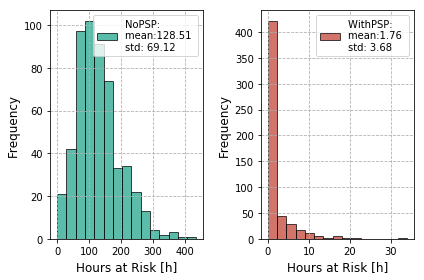

In [97]:
plt.subplot(1,2,1)
har_np = hoursAtRisk(resLoad_b, reliableCap_noPump, saveFig=False, 
            figName='HoursAtRisk_withoutPump.pdf', color=c_pump, case='NoPSP: ')
plt.grid(linestyle='--')
plt.subplot(1,2,2)
har_p = hoursAtRisk(resLoad_b, reliableCap_pump, saveFig=False, 
            figName='HoursAtRisk_withPump.pdf', color=c_noPump, case='WithPSP: ')
plt.grid(linestyle='--')
plt.savefig(outLoc+'/'+'HoursAtRisk_2.pdf')

In [41]:
har_p.quantile(0.65)

1.0

## Maximum Load at Risk

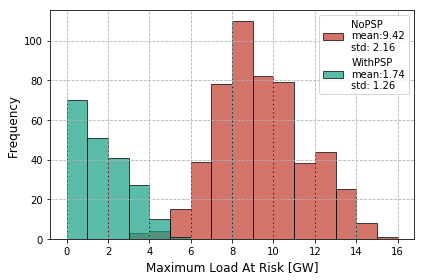

In [78]:
def maxLoadRisk(resLoad, reliableCap, saveFig, figName, color, case):
    loadAtRisk = ((resLoad[resLoad>reliableCap] - reliableCap)/1000).max()
    stat = case+'\nmean:%.2f\nstd: %.2f'% (loadAtRisk.mean(), loadAtRisk.std())
    plt.hist(loadAtRisk, bins=16, 
             label=stat, range=(0,16), 
             edgecolor='black', 
             color=color, alpha=0.7)
    plt.xlabel('Maximum Load At Risk [GW]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    #plt.xlim([0,20])
    #plt.ylim([0,60])
    plt.legend()
    plt.tight_layout()
    if saveFig:
        plt.savefig(outLoc+"/"+figName)
    
    
maxLoadRisk(resLoad_b, reliableCap_w, saveFig=False, figName='as', 
            color=c_withoutPump, case='NoPSP')
maxLoadRisk(resLoad_b, reliableCap_b_ne, saveFig=False, figName='as', 
            color=c_withPump, case='WithPSP')
plt.grid(linestyle='--')
plt.savefig(outLoc+'/MaxLoadAtRisk_2.pdf')

# Load at Risk

In [80]:
def loadRisk(resLoad, reliableCap, saveFig, figName, color, case):
    loadAtRisk = [] 
    loadAtRiskDF = ((resLoad[resLoad>reliableCap] - reliableCap)/1000)
    count = 1
    for col in loadAtRiskDF.columns:
        loadIns = loadAtRiskDF[[col]]
        loadVals = loadIns[loadIns[col].notnull()].values.flatten()
        loadAtRisk.append(list(loadVals))
        count= count+1
        
    loadAtRisk = np.hstack(loadAtRisk)
    
    stat = case+'\nmean:%.2f\nstd: %.2f'% (loadAtRisk.mean(), loadAtRisk.std())
    plt.hist(loadAtRisk, bins=20, label=stat,  
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Load At Risk [GW]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    #plt.xlim([0,20])
    #plt.ylim([0,60])
    plt.legend()
    plt.tight_layout()
    if saveFig:
        plt.savefig(outLoc+"/"+figName)

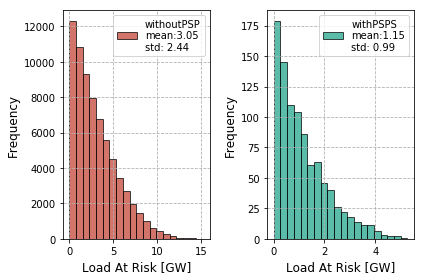

In [99]:
plt.subplot(1,2,1)
plt.grid(linestyle='--')
loadRisk(resLoad_b, reliableCap_w, saveFig=False, 
         figName='asas', color=c_withoutPump, case='withoutPSP')
plt.subplot(1,2,2)
loadRisk(resLoad_b, reliableCap_b_ne, saveFig=False, 
         figName='asas', color=c_withPump, case='withPSPS')
plt.grid(linestyle='--')
plt.tight_layout()
#plt.savefig(outLoc+'/LoadAtRisk_2.pdf')

## Energy at risk

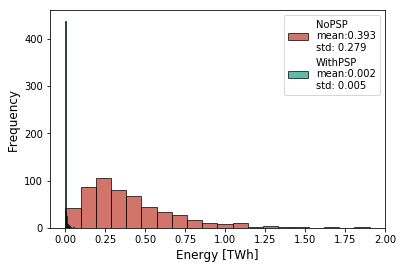

In [270]:
def energyAtRisk(resLoad, reliableCap, color, case, saveFig=False, figName=False):
    energyAtRisk=((resLoad[resLoad>reliableCap] - reliableCap)/1000000).sum()
    stat = case+'\nmean:%.3f\nstd: %.3f'% (energyAtRisk.mean(), energyAtRisk.std())
    plt.hist(energyAtRisk, bins=20, label=stat,  
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Energy [TWh]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    #plt.show()
    
energyAtRisk(resLoad_b, reliableCap_w, color=c_withoutPump, case='NoPSP')
energyAtRisk(resLoad_b, reliableCap_b_ne, color=c_withPump, case='WithPSP')

plt.savefig(outLoc+'/EnergyAtRisk.pdf')